# <b>背景</b>

目前妊娠期糖尿病（GDM）的诊断依靠糖耐量试验（OGTT），一种葡萄糖负荷试验，用以了解胰岛β细胞功能和机体对血糖的调节能力，是诊断糖尿病的确诊试验。诊断GDM的标准为空腹血糖≥5.1mmol/L，1小时≥10.0mmol/L，2小时大于等于8.5mmol/L。如果空腹血糖≥7.0mmol/L，或者2小时血糖大于≥11.1mmol/L，则诊断为糖尿病DM。

糖化血红蛋白（HbA1c）是判断糖尿病患者血糖控制良好与否非常重要的一个指标，可以反映患者近8-12周的血糖控制情况。糖化血红蛋白（HbA1c）在妊娠期没有明确的参考值范围，当HbA1c≥6.5%，则诊断为DM。对于诊断GDM则没有参考值。

# <b>任务</b>

 |前置条件检验 （ 正态性、方差齐性 ）

 |组间差异显著性检验 （ one-way anova test ）

 |独立性检验 （ 卡方检验 ）

 |相关性检验 （ pearson,spearson ）

# <b>第一步 引包 </b>

In [1]:
#引包：引入所需python包
import xlrd
import os
import re
import time
import itertools
import pandas as pd
import numpy as np
from numpy import nan
from sklearn.metrics import roc_curve,auc
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from scipy.stats import chisquare   
from scipy.stats import chi2
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# <b>第二步 获取数据源</b>
设置默认文件目录

读取csv文件

In [2]:
dir = "./output/"
print(os.listdir(dir))

['clean_data.csv']


In [28]:
HbA1c_ref = pd.read_csv(dir+"clean_data.csv",index_col=0) #第一列为行索引
HbA1c_ref = HbA1c_ref.drop(columns = HbA1c_ref.columns[0]) #删除不需要的列
HbA1c_ref.head(2)

,INSPECTION_ID,登记号,检查日期,检验目的,审核时间,项目名称,HbA1c,单位,参考值,year,age,age_range,OGTT_date,OGTT_0,OGTT_1,OGTT_2,STATUS
107,20160104G0460006,20422685.0,20160104,糖化血红蛋白,2016-01-04 12:16:12,糖化血红蛋白A1c,5.5,%,4.1-6.8,2016,29,"(22.0, 30.0]",20160104,4.9,8.4,7.4,health
219,20160107G0460006,20185957.0,20160107,糖化血红蛋白,2016-01-07 14:43:57,糖化血红蛋白A1c,5.2,%,4.1-6.8,2016,36,"(35.0, 42.0]",20160107,4.8,7.4,5.3,health


# <b> 第三步 统计推断 </b>

统计推断任务是先根据实际情况提出原假设H0与备择假设H1，然后寻找适当的检验统计量进行假设检验。

### <b> 3.1 前提条件检验 </b>

在进行一些检验前，一般都有些前提条件,我们可以首先对这些条件进行检验，方便后面检验方法的选择和使用。一般的前提条件是：正态性和方差齐性。

正态和方差齐性检验用于了解组间的差异，以及服务于后面的检验方法的选择：

正态性检验 ： 利用观测数据判断总体是否服从正态分布的检验称为正态性检验，它是统计判决中重要的一种特殊的拟合优度假设检验。
                H0 : 总体服从正态分布  H1: 总体不服从正态分布
            P 值 ≤ α：数据不服从正态分布（否定 H0）
               如果 p 值小于或等于显著性水平，则决策为否定原假设并得出数据不服从正态分布的结论。
            P 值 > α：您无法得出数据不服从正态分布的结论（无法否定 H0）
            
方差齐性检验 ： 是数理统计学中检查不同样本的总体方差是否相同的一种方法。其基本原理是先对总体的特征作出某种假设，然后通过抽样研究的统计推理，对此假设应该被拒绝还是接受作出推断。
                H0 : 方差齐性/整齐  H1: 方差不整齐
            P 值 ≤ α：数据方差不整齐（否定 H0）
   如果 p 值小于或等于显著性水平，则决策为否定原假设并得出各组数据方差不整齐的结论。  
   P 值 > α：您无法得出数据方差不整齐的结论（无法否定 H0）

In [29]:
print ("3个组一起的总体检验：\n")
for col in ["age","HbA1c","OGTT_0","OGTT_1","OGTT_2"]:
    col1 = HbA1c_ref[col].dropna(axis = 0)
    vp = kstest(col1, 'norm')    # 正态性检验
    print (col,"正态性检验:" ,vp) 
    
    test = HbA1c_ref[~np.isnan(HbA1c_ref[col])]
    group1 = test[test["STATUS"] =="health"][col]
    group2 = test[test["STATUS"] =="GDM"][col]
    group3 = test[test["STATUS"] =="DM"][col]
    args =[group1,group2,group3]
    w,p = stats.levene(*args)  #center = "trimmed"离差
    print (col,"方差齐性检验 :statistic=",w,",pvalue=",p)   
#statistic 越大 ，pvalue越小

3个组一起的总体检验：

age 正态性检验: KstestResult(statistic=1.0, pvalue=0.0)
age 方差齐性检验 :statistic= 4.447404339601408 ,pvalue= 0.011732475113110012
HbA1c 正态性检验: KstestResult(statistic=0.9995614343891661, pvalue=0.0)
HbA1c 方差齐性检验 :statistic= 48.29476853277005 ,pvalue= 1.3432670259868527e-21
OGTT_0 正态性检验: KstestResult(statistic=0.9994596533217927, pvalue=0.0)
OGTT_0 方差齐性检验 :statistic= 878.0037998471173 ,pvalue= 0.0
OGTT_1 正态性检验: KstestResult(statistic=0.9991154276312125, pvalue=0.0)
OGTT_1 方差齐性检验 :statistic= 23.145263652549552 ,pvalue= 9.379548607063297e-11
OGTT_2 正态性检验: KstestResult(statistic=0.9991429563096625, pvalue=0.0)
OGTT_2 方差齐性检验 :statistic= 69.0461555430269 ,pvalue= 1.687052022382083e-30


从结果来看：不同健康人群组间“年龄”、HbA1c1和OGTT检测结果正态性和方差齐性不满足。

### <b> 3.2 组间差异显著性检验 </b>
<b> 1) 单因素方差分析  </b>

单因素方差分析(one-way anova test) :是指对单因素试验结果进行分析，检验因素对试验结果有无显著性影响的方法。
H0 : 组间差异不显著，p > α ； H1： 组间差异显著 ，p < α，否定原假设

前提条件：服从正态分布，且方差相同。

In [30]:
# one way anova
import statsmodels.api as sm
from statsmodels.formula.api import ols
result = pd.DataFrame()
for col in ["age","HbA1c","OGTT_0","OGTT_1","OGTT_2"]: 
    mod = ols(col+' ~ STATUS',data=HbA1c_ref).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    line = pd.DataFrame(aov_table)
    result = result.append(line)
result = result.drop("Residual")
result.index = ["age","HbA1c","OGTT_0","OGTT_1","OGTT_2"]
result

,sum_sq,df,F,PR(>F)
age,4725.521712,2.0,146.747589,1.587344e-63
HbA1c,110.983802,2.0,423.652585,3.214937e-177
OGTT_0,641.140794,2.0,2467.295430,0.000000e+00
OGTT_1,12524.224427,2.0,3303.281016,0.000000e+00
OGTT_2,10670.324906,2.0,4682.052568,0.000000e+00


从结果来看：组间年龄和测试结果的差异显著，但因ANOVA的前提条件正态性和方差性不满足，该结果不可靠。

需要选用其他检验方法。

<b> 2) 非参数检验 </b>

Wilcoxon秩和检验（或Mann–Whitney U检验）

目的：检验两组独立样本的是否存在差异性

假设：H0: 两总体分布中心位置相同

     H1: 两总体分布中心位置不同

In [31]:
print ("3个组两两配对的检验：\n")
result = pd.DataFrame()
for col in ["age","HbA1c","OGTT_0","OGTT_1","OGTT_2"]:
    for i in itertools.combinations(["health","GDM","DM"],2):
        test = HbA1c_ref[~np.isnan(HbA1c_ref[col])]        
        data1 = test.loc[test["STATUS"] == i[0] , col].values
        data2 = test.loc[~(test["STATUS"] == i[1]) , col].values                
        s,p= mannwhitneyu(data1,data2)
        line = [(i,col,s,p)]
        result = result.append(line)
result.columns = ["组"," 变量 ","U检验 统计值","p值(a=0.05)"]        
result["推断"] =[ "组间有差异" if x<0.05 else "无差异"  for x in  result["p值(a=0.05)"] ]      #,  
result.head(10)
#中位数，四分位数

3个组两两配对的检验：



,组,变量,U检验 统计值,p值(a=0.05),推断
0,"(health, GDM)",age,27285336.5,2.375422e-01,无差异
0,"(health, DM)",age,34003840.5,2.548956e-08,组间有差异
0,"(GDM, DM)",age,9771880.5,1.874928e-30,组间有差异
0,"(health, GDM)",HbA1c,27193441.0,1.424855e-01,无差异
0,"(health, DM)",HbA1c,32912535.0,3.087872e-19,组间有差异
0,"(GDM, DM)",HbA1c,8680575.0,1.298714e-77,组间有差异
0,"(health, GDM)",OGTT_0,27058806.5,7.371986e-02,无差异
0,"(health, DM)",OGTT_0,30181567.5,8.859677e-68,组间有差异
0,"(GDM, DM)",OGTT_0,5981628.0,6.883868e-289,组间有差异
0,"(health, GDM)",OGTT_1,25771281.5,4.547973e-02,组间有差异


### <b> 3.3 独立性检验 </b>

基于卡方的独立性检验


目的：检验单个多项分类名义型变量各分类间的实际观测次数与理论次数之间是否一致的问题

前提条件：对正态性和方差齐性没要求

假设：
            H0 : 类别A与B的比例没有差异
            
            H1 : 类别A与B的比例有差异
            
<b> 1) 不同年龄组的检验 
    先计算列联表

In [32]:
HbA1c_ref["count"] = 1
stat_age_range= HbA1c_ref.pivot_table(index= "age_range",columns = "STATUS",values="count", aggfunc =len,fill_value=0  )
#stat_age_range.loc["total"]=[sum(stat_age_range["DM"]),sum(stat_age_range["GDM"]),sum(stat_age_range["health"])]
stat_age_range["DM%"] = stat_age_range["DM"]/(stat_age_range["DM"]+stat_age_range["GDM"]+stat_age_range["health"])*100
stat_age_range["GDM%"] = stat_age_range["GDM"]/(stat_age_range["DM"]+stat_age_range["GDM"]+stat_age_range["health"])*100
stat_age_range

STATUS,DM,GDM,health,DM%,GDM%
age_range,,,,,
"(0.0, 22.0]",0,10,116,0.000000,7.936508
"(22.0, 30.0]",29,1035,4192,0.551750,19.691781
"(30.0, 35.0]",53,936,2385,1.570836,27.741553
"(35.0, 42.0]",36,363,644,3.451582,34.803452
"(42.0, 50.0]",1,23,16,2.500000,57.500000


In [33]:
data = stat_age_range.iloc[0:5:,3:5]   #构成比例
data["health%"] = 100-data["DM%"]-data["GDM%"]
data = (data*100).astype("int")
chis,p_value = chisquare(data)   #整体
print("三组的占比的卡方检验  ： \n")
print(p_value)

三组的占比的卡方检验  ： 

[1.48623907e-104 0.00000000e+000 0.00000000e+000]


在α = 0.05水平上，不同年龄组中DM、GDM和health占比差异显著

In [34]:
ages = ['(22.0, 30.0]', '(30.0, 35.0]','(35.0, 42.0]']
result = pd.DataFrame()

print("占比（患病率）的卡方检验  ： \n")
for i in itertools.combinations(ages,2):
    test = data[(data.index ==i[0]) | (data.index ==i[1]) ]   
    #chi2_fitting(data,0.05)
    chis,p_value = chisquare(test)
    line = [(i[0],i[1],p_value[0],p_value[1],p_value[2])]
    result = result.append(line)
result.columns = ["组1"," 组2","DM p值","GDM p值" ,"health p值"]    
result.head(4)

占比（患病率）的卡方检验  ： 



,组1,组2,DM p值,GDM p值,health p值
0,"(22.0, 30.0]","(30.0, 35.0]",2.463010e-12,1.454549e-31,1.413742e-13
0,"(22.0, 30.0]","(35.0, 42.0]",1.211499e-47,4.031885e-93,8.705398e-52
0,"(30.0, 35.0]","(35.0, 42.0]",4.826372e-17,4.360758e-19,7.915727e-15


从结果来看：不同年龄组之间患病率呈显著性差异，非独立。

###  <b> 3.4 相关性检验  </b>

检验HbAc1是否和年龄、OGTT等检测结果有相关性。

方法： pearson检验,前提条件数据符合正态分布

       spearman检验，无前提条件因此，本文中spearman更适合
       
假设：H0：ρ=0（相关系数ρ=0的总体中抽出的样本），H1：ρ≠0 

<b> 1) 计算相关系数 </b>

In [35]:
test = HbA1c_ref.filter(items=["HbA1c","OGTT_0","OGTT_1","OGTT_2","age"])  #
test=test.corr()   #test.corr()["HbA1c"]
test

,HbA1c,OGTT_0,OGTT_1,OGTT_2,age
HbA1c,1.000000,0.345637,0.282016,0.294639,0.159209
OGTT_0,0.345637,1.000000,0.479659,0.469996,0.157027
OGTT_1,0.282016,0.479659,1.000000,0.727076,0.221067
OGTT_2,0.294639,0.469996,0.727076,1.000000,0.216008
age,0.159209,0.157027,0.221067,0.216008,1.000000


<b>2） 相关性检验 </b>

In [36]:
fields = ["HbA1c","OGTT_0","OGTT_1","OGTT_2"]
print("各检查结果相关性检验  ： \n")
for i in itertools.combinations(fields,2):
   
    x1 = HbA1c_ref[i[0]] 
    y1 = HbA1c_ref[i[1]]
    x = x1[x1.notnull() & y1.notnull() ] 
    y = y1[x1.notnull() & y1.notnull() ]    
    stat_val, p_val = stats.ttest_ind(x, y, equal_var=False)

    r, p=stats.pearsonr(x,y)
    print(i ,"的Pearson相关性系数",r,"和P_value :",p)   
    r , p =stats.spearmanr(x,y)    
    print(i ,"的Spearman相关性系数",r,"和P_value :",p)  

各检查结果相关性检验  ： 

('HbA1c', 'OGTT_0') 的Pearson相关性系数 0.34563711209853953 和P_value : 6.256449504115339e-274
('HbA1c', 'OGTT_0') 的Spearman相关性系数 0.28886311658369496 和P_value : 2.889848480419551e-188
('HbA1c', 'OGTT_1') 的Pearson相关性系数 0.28201577754110796 和P_value : 7.125809822852736e-176
('HbA1c', 'OGTT_1') 的Spearman相关性系数 0.24775126044068538 和P_value : 6.577590396441371e-135
('HbA1c', 'OGTT_2') 的Pearson相关性系数 0.29463927124311695 和P_value : 9.796825036704723e-192
('HbA1c', 'OGTT_2') 的Spearman相关性系数 0.26182075289726864 和P_value : 2.2369907048759633e-150
('OGTT_0', 'OGTT_1') 的Pearson相关性系数 0.4796590752586375 和P_value : 0.0
('OGTT_0', 'OGTT_1') 的Spearman相关性系数 0.38046764193024635 和P_value : 0.0
('OGTT_0', 'OGTT_2') 的Pearson相关性系数 0.4699957338425628 和P_value : 0.0
('OGTT_0', 'OGTT_2') 的Spearman相关性系数 0.36109771335453106 和P_value : 1.2789459189541954e-293
('OGTT_1', 'OGTT_2') 的Pearson相关性系数 0.7270761206068339 和P_value : 0.0
('OGTT_1', 'OGTT_2') 的Spearman相关性系数 0.6843436630115042 和P_value : 0.0


从spearman结果来看：p值都是极小值，各个检查结果之间相关性具有统计学意义。 

<b> 3) 可视化 </b>

可以通过图表来直观了解数据直接的关系。

热力图

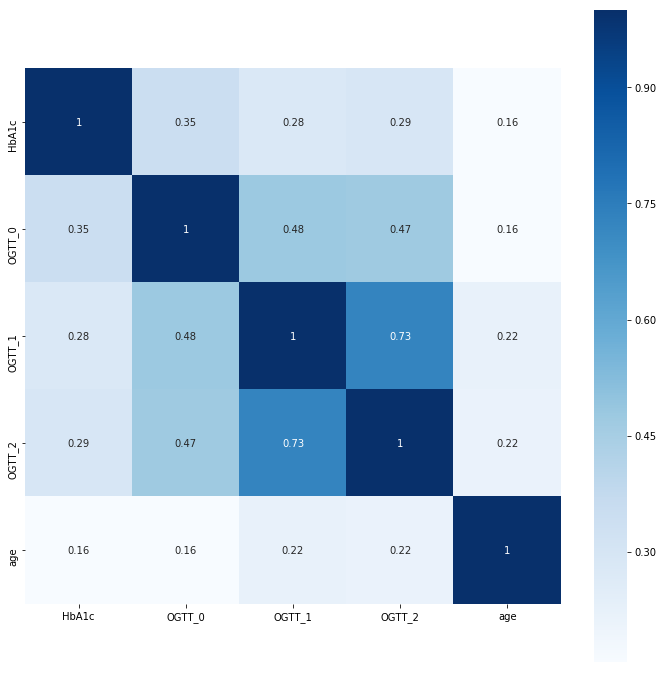

In [37]:
plt.subplots(figsize=(12, 12)) # 设置画面大小
sns.heatmap(test, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

散点图

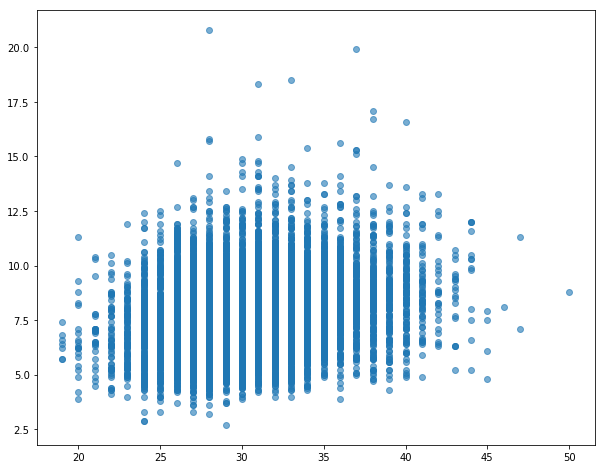

In [38]:
plt.subplots(figsize=(10, 8))
x = HbA1c_ref["age"]
y = HbA1c_ref["OGTT_1"]
plt.scatter(x, y, alpha=0.6)  # 绘制散点图，透明度为0.6（这样颜色浅一点，比较好看）
plt.show()